In [1]:
import relative_imports
import torch

In [2]:
device = torch.device("cuda:3")

# Load dataset manager

In [3]:
from spatiotemporal.SEN12MSCRTS import DatasetManager
from spatiotemporal.mods import ZeroPixelsS2, CategoricalCloudMaps, CloudfreeArea
import pandas as pd

In [4]:
root_dir = '/LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRTS'
cloud_maps_dir = "/LOCAL2/shvl/datasets/cloud_removal/SEN12MSCRTS_cloud_maps"
dataset_manager = DatasetManager(
    root_dir=root_dir,
    cloud_maps_dir=cloud_maps_dir,
    cloud_probability_threshold=0.35
)
dataset_manager.load_from_file()

In [5]:
ZeroPixelsS2(dataset_manager).apply_modification(verbose=True)
CategoricalCloudMaps(dataset_manager).apply_modification(verbose=True)
CloudfreeArea(dataset_manager).apply_modification(verbose=True)

Fixing zero pixels in S2 images...
Adding categorical cloud maps...
Adding cloudfree area percentages for threshold 35...


# Define old data processing pipeline

In [30]:
import pandas as pd
import numpy as np
from os.path import join

In [31]:
project_directory = dataset_manager.project_directory
project_directory

'/home/mathe/lvhome10/users/students/shvl/projects/CTGAN/spatiotemporal'

In [36]:
legacy_min_max = pd.read_csv(join(project_directory, "stats", "DEPRECATED_98_percentile_min_max.csv"), index_col="band")
legacy_min_max

,min,max
band,,
0,0.0,3450.0
1,0.0,3060.0
2,0.0,3020.0
3,0.0,3670.0
4,0.0,3830.0
5,0.0,4120.0
6,0.0,4490.0
7,0.0,4380.0
8,0.0,4640.0


In [37]:
def rescale_s2(image):
    rescaled_target = dataset_manager.utils.rescale(
        image,
        bands_min=legacy_min_max["min"], 
        bands_max=legacy_min_max["max"],
        for_tanh=True, 
        clip=True
    )
    if rescaled_target.ndim == 3:
        rescaled_target = rescaled_target[[3, 2, 1, 7]]
    elif rescaled_target.ndim == 4:
        rescaled_target = rescaled_target[:, [3, 2, 1, 7]]
    else:
        raise ValueError("Could not rescale target")
    
    return rescaled_target
    
def rescale_s2_back(image):  # input is in [0..1]
    
    if not image.ndim == 3:
        raise ValueError("Image dimensions must be 3")

    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().numpy()
        
    unrescaled_image = dataset_manager.utils.rescale_back(
        image,
        bands_min=legacy_min_max["min"].astype(image.dtype), 
        bands_max=legacy_min_max["max"].astype(image.dtype),
        bands=[3, 2, 1, 7]
    )
    unrescaled_image = np.clip(unrescaled_image, 0.0, 10000.0)
    unrescaled_image = np.rint(unrescaled_image).astype(np.uint16)
    return unrescaled_image

In [38]:
def legacy_rescale_s2(s2_image, old_version=True):

    BANDS = [3, 2, 1, 7]

    if s2_image.ndim == 3 and s2_image.shape[0] == 13:
        celected_bands = (BANDS, slice(None), slice(None))
    elif s2_image.ndim == 4 and s2_image.shape[1] == 13:
        celected_bands = (slice(None), BANDS, slice(None), slice(None))
    else:
        raise ValueError(f"Only accept images of shape [(batch), band, height, width] with 13 bands. "
                         f"Got instead: {s2_image.shape}")

    bands_min = legacy_min_max["min"].values[:, np.newaxis, np.newaxis].astype(np.float32)
    bands_max = legacy_min_max["max"].values[:, np.newaxis, np.newaxis].astype(np.float32)

    if s2_image.ndim == 4:
        bands_min = bands_min[np.newaxis, ...]
        bands_max = bands_max[np.newaxis, ...]

    if isinstance(s2_image, torch.Tensor):
        bands_min = torch.from_numpy(bands_min).to(device=s2_image.device)
        bands_max = torch.from_numpy(bands_max).to(device=s2_image.device)

    rescaled_image = s2_image.clip(min=bands_min, max=bands_max)
    rescaled_image = rescaled_image - bands_min
    rescaled_image = rescaled_image / (bands_max - bands_min)

    if old_version:
        rescaled_image = rescaled_image - 0.5
        rescaled_image = rescaled_image * 2

    return rescaled_image[celected_bands]

# Note changes between refactored and old models

## Data

- RUN006 was last modified on **2023-02-11**, training performed on the same date
- RUN_010 was last modified on **2024-03-24**, training was run however on **2023-02-12**, so very old model code was used
- RUN_S1_002 was last modified on **2024-09-17**, training was run on **2023-02-14**
- possible relevant commit in CTGAN: 12.02.2023

Data was possibly rescaled to (-1, 1), as indicated in one of the commits. The rescaling was done in SEN12MS-CR-TS loader.

Dataset class which was used is CTGANTorchIterableDataset, which was in file ctgan_dataset.py in module spatiotemporal. Date: 10.02.2023

Possible state of spatiotemporal at thate time: Commit 824cbc2108dc52858d12501cade179a063934d1e

Rescaling was done using function self.rescale_s2(image)[self.bands] from dataset_manager.ImageUtils. Steps:
- clip image to min/max values per band
- subtract min band, divide by max-min. This leaves us with a [0..1] value range
- rescale to [-1..1] value range

File used for rescaling: min_max = pd.read_csv(join(project_directory, "98_percentile_min_max.csv"), index_col="band")

Both input images and output images were rescaled this way.

### Clouds

Cloud map probability threshold was most possibly set to 0.5. However, in some places the default threshold is 0.05.

Cloud maps were filtered with scipy.ndimage.gaussian filter with sigma=2

CTGANTorchIterableDataset implements the sample selection based on cloud cover. 


## CTGAN Module

### Feature Extractor
- Final activation was probably tanh() and not sigmoid(). This is not critical, as it is only used to produce aux predictions.

### Model component
- No changes!

### CTGAN
- In Conformer_Module():
    - submodule name was self.comformer (with a typo) instead of conformer
- In CTGAN_Generator():
    - in submodule self.model_final the final activation was probably Tanh() instead of Sigmoid()
- In CTGAN_Discriminator():
    - multiple changes to nn.Conv2() layers, e.g. kernel sizes and padding. This is not relevant, since we don't need a discriminator anyway
- In utils:
    - multiple changes to GANLoss(). These are not relevant, since we don't need that loss anyway

# Load dataset

In [ ]:
from CTGAN.datasets.s2_dataset import CTGAN_S2_Dataset

In [6]:
dataset = CTGAN_S2_Dataset(dataset_manager, min_target_area=0.95, min_inputs_area=0.5, rescale=False, filter_bands=False)
len(dataset)

156684

In [7]:
dataset = dataset.subset(s1_resampled=True, split="val", inplace=True)
# dataset_test = dataset.subset(s1_resampled=True, split="test", inplace=False)
# dataset.data = pd.concat([dataset_val.data, dataset_test.data], join="outer", axis=0)
# del dataset_val
# del dataset_test

In [8]:
len(dataset)

15339

### Prepare batch loader

In [9]:
from torch.utils.data import DataLoader

In [10]:
val_loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=0,
    pin_memory=True,
    drop_last=False,
    shuffle=False
)

In [11]:
val_iterator = iter(val_loader)

In [12]:
batch = next(val_iterator)
batch = {
    name: tensor.to(device=device, dtype=torch.float32, non_blocking=True)
    for name, tensor in batch.items()
}

In [13]:
batch['S2CLOUDMASK_t-1'].sum(), batch['S2CLOUDMASK_t-2'].sum(), batch['S2CLOUDMASK_t-3'].sum()

(tensor(65536., device='cuda:3'),
 tensor(0., device='cuda:3'),
 tensor(0., device='cuda:3'))

In [14]:
inputs = [batch["S2_t-1"], batch["S2_t-2"], batch["S2_t-3"]]

In [15]:
inputs[0].shape, inputs[0].device, inputs[0].dtype, inputs[0].min(), inputs[0].max()

(torch.Size([1, 13, 256, 256]),
 device(type='cuda', index=3),
 torch.float32,
 tensor(7., device='cuda:3'),
 tensor(10522., device='cuda:3'))

### Example image

In [16]:
from matplotlib import pyplot as plt

In [17]:
sample_image = dataset[0]["S2_t0"]
sample_image.shape, sample_image.dtype, sample_image.min(), sample_image.max()

((13, 256, 256), dtype('float32'), 39.0, 5098.0)

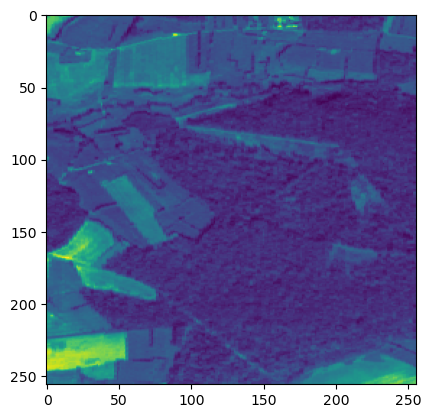

In [18]:
plt.imshow(sample_image[2])
plt.show()

# Load Generator checkpoint

In [41]:
from os.path import join
from os import listdir
import torch
import pprint

In [42]:
path_to_checkpoints = "/LOCAL2/shvl/checkpoints/CTGAN/SEN12MS-CR-TS/RUN_010"

In [43]:
checkpoint_filenames = listdir(path_to_checkpoints)
len(checkpoint_filenames)

448

In [44]:
discriminator_filenames = [filename for filename in checkpoint_filenames if filename.startswith("RUN_010_D")]
generator_filenames = [filename for filename in checkpoint_filenames if filename.startswith("RUN_010_G")]
generator_filenames.sort()

In [45]:
checkpoint_filename = generator_filenames[124]
checkpoint_filename

'RUN_010_G_step_156000.pth'

In [46]:
checkpoint_filepath = join(path_to_checkpoints, checkpoint_filename)
checkpoint_filepath

'/LOCAL2/shvl/checkpoints/CTGAN/SEN12MS-CR-TS/RUN_010/RUN_010_G_step_156000.pth'

In [47]:
state_dict = {key.replace("comformer", "conformer"): value for key, value in torch.load(checkpoint_filepath).items()}
len(state_dict.keys())

228

### Try loading the model

In [48]:
from CTGAN.model.CTGAN import CTGAN_Generator

In [56]:
model = CTGAN_Generator(image_size=256)

In [57]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [58]:
model = model.to(device)

In [61]:
_ = model.eval()

In [62]:
with torch.no_grad():
    prediction, _, _ = model([rescale_s2(tensor).to(device) for tensor in inputs])

prediction.shape

torch.Size([1, 4, 256, 256])

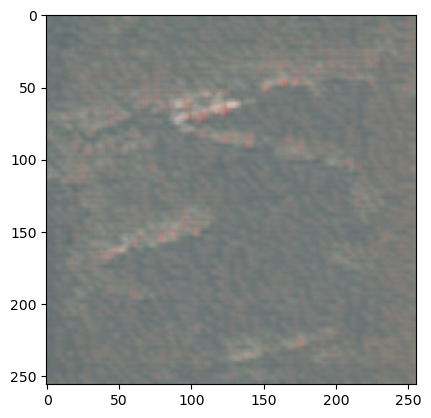

In [63]:
plt.imshow(prediction[0, :3].moveaxis(0, -1).detach().cpu())
plt.show()

# Prepare for validation

In [39]:
from torch.utils.data._utils.collate import default_collate
from torch.utils.data import DataLoader
from parse import parse

In [40]:
_ = model.eval()

In [41]:
generator_filenames_schema = "RUN_010_G_step_{step:d}.pth"

training_steps = {}

for filename in generator_filenames:
    parsed_data = parse(generator_filenames_schema, filename)
    if parsed_data is None:
        continue
    recovered_step = parsed_data.named["step"]
    if recovered_step < 30000:
        continue
    training_steps[parsed_data.named["step"]] = filename

In [42]:
training_steps = dict(sorted(training_steps.items()))

In [43]:
len(training_steps)

134

In [44]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [45]:
result_df = pd.DataFrame(
    0.0,
    index=list(training_steps.keys()),
    columns=["SSIM11", "SSIM51", "PSNR"]
)
result_df

,SSIM11,SSIM51,PSNR
30000,0.0,0.0,0.0
31000,0.0,0.0,0.0
32000,0.0,0.0,0.0
33000,0.0,0.0,0.0
34000,0.0,0.0,0.0
...,...,...,...
159000,0.0,0.0,0.0
160000,0.0,0.0,0.0
161000,0.0,0.0,0.0
162000,0.0,0.0,0.0


In [46]:
from CTGAN.train import Trainer
from tqdm import tqdm

In [47]:
val_loader = DataLoader(
    dataset,
    batch_size=64,
    num_workers=16,
    pin_memory=True,
    drop_last=False,
    shuffle=True
)

val_iterator = Trainer.infinite(val_loader)

In [48]:
path_to_checkpoints = "/LOCAL2/shvl/checkpoints/CTGAN/SEN12MS-CR-TS/RUN_010"

In [50]:
generator = model

for training_step, model_filename in tqdm(training_steps.items()):
    
    state_dict = torch.load(join(path_to_checkpoints, model_filename))
    state_dict = {key.replace("comformer", "conformer"): value for key, value in state_dict.items()}
    
    generator.load_state_dict(state_dict)
    generator = generator.to(device)

    batch = next(val_iterator)
    batch = {
        name: tensor.to(device=device, dtype=torch.float32, non_blocking=True)
        for name, tensor in batch.items()
    }
    inputs = [batch["S2_t-1"], batch["S2_t-2"], batch["S2_t-3"]]
    inputs = [rescale_s2(image) for image in inputs]
    target = batch["S2_t0"]
    target = legacy_rescale_s2(target, old_version=False)

    with torch.no_grad():
        prediction, [att0, att1, att2], [pred_0, pred_1, pred_2] = generator(inputs)

    ssim11_values = []
    ssim51_values = []
    psnr_values = []
    
    for image_num in range(prediction.shape[0]):
        
        ssim11_value = ssim(
            prediction[image_num].cpu().numpy(),
            target[image_num].cpu().numpy(),
            win_size=11,
            data_range=1.0,
            channel_axis=0
        )
        ssim51_value = ssim(
            prediction[image_num].cpu().numpy(),
            target[image_num].cpu().numpy(),
            win_size=51,
            data_range=1.0,
            channel_axis=0
        )
        psnr_value = psnr(
            prediction[image_num].cpu().numpy(),
            target[image_num].cpu().numpy(),
            data_range=1.0,
        )
        ssim11_values.append(ssim11_value)
        ssim51_values.append(ssim51_value)
        psnr_values.append(psnr_value)

    result_df.loc[training_step, "SSIM11"] = np.mean(ssim11_values)
    result_df.loc[training_step, "SSIM51"] = np.mean(ssim51_values)
    result_df.loc[training_step, "PSNR"] = np.mean(psnr_values)

100%|█████████████████████████████████████████| 134/134 [23:59<00:00, 10.74s/it]


In [51]:
result_df

,SSIM11,SSIM51,PSNR
30000,0.507971,0.424574,20.000512
31000,0.491463,0.408570,19.453269
32000,0.484233,0.405186,19.617005
33000,0.491207,0.418165,19.593538
34000,0.503973,0.431865,19.411563
...,...,...,...
159000,0.682832,0.650652,20.865076
160000,0.700223,0.673845,20.321401
161000,0.664795,0.639780,19.050411
162000,0.705159,0.686752,20.484058


In [52]:
result_df.to_csv("CTGAN_metrics_per_step.csv")

In [88]:
result_df = pd.read_csv("CTGAN_metrics_per_step.csv", index_col=0)
result_df

,SSIM11,SSIM51,PSNR
30000,0.507971,0.424574,20.000512
31000,0.491463,0.408570,19.453269
32000,0.484233,0.405186,19.617005
33000,0.491207,0.418165,19.593538
34000,0.503973,0.431865,19.411563
...,...,...,...
159000,0.682832,0.650652,20.865076
160000,0.700223,0.673845,20.321401
161000,0.664795,0.639780,19.050411
162000,0.705159,0.686752,20.484058


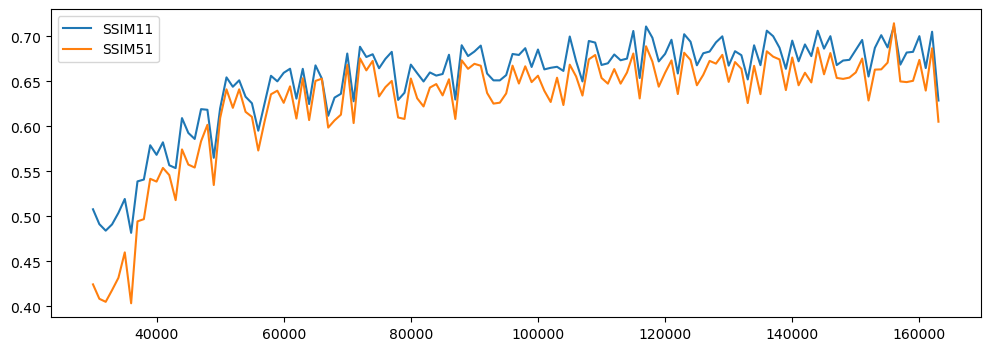

In [89]:
plt.figure(figsize=(12, 4))
plt.plot(result_df.index, result_df["SSIM11"], label="SSIM11")
plt.plot(result_df.index, result_df["SSIM51"], label="SSIM51")
plt.legend()
plt.show()

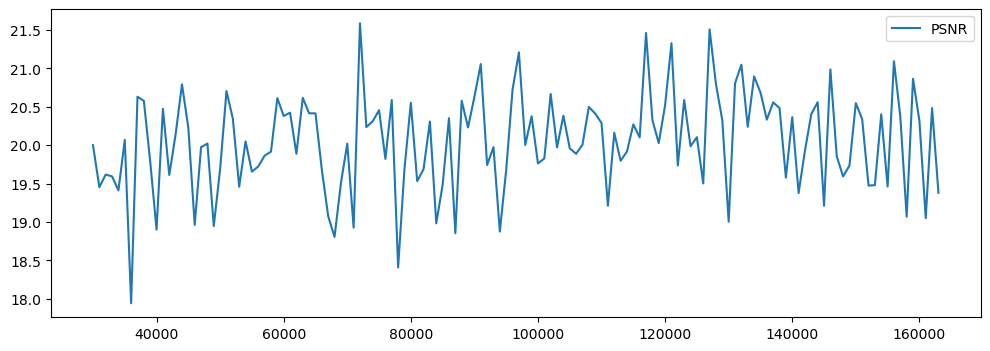

In [90]:
plt.figure(figsize=(12, 4))
plt.plot(result_df.index, result_df["PSNR"], label="PSNR")
plt.legend()
plt.show()

In [94]:
best_ssim11 = result_df.loc[110000:130000]
best_ssim11 = best_ssim51[best_ssim51["SSIM51"] == best_ssim51["SSIM51"].max()]
best_ssim11

,SSIM11,SSIM51,PSNR
117000,0.710989,0.689022,21.461689


In [95]:
best_step = best_ssim11.index.item()
best_step

117000

# Load best model

In [49]:
best_step = 117000

In [50]:
from os.path import join
from CTGAN.train import Trainer
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch

In [51]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from CTGAN.model.CTGAN import CTGAN_Generator

In [52]:
from torch.utils.data import DataLoader

In [53]:
path_to_checkpoints = "/LOCAL2/shvl/checkpoints/CTGAN/SEN12MS-CR-TS/RUN_010"
generator_filenames_schema = "RUN_010_G_step_{step:d}.pth"
best_checkpoint = generator_filenames_schema.format(step=best_step)
path_to_checkpoint = join(path_to_checkpoints, best_checkpoint)

In [54]:
state_dict = {key.replace("comformer", "conformer"): value for key, value in torch.load(path_to_checkpoint).items()}

In [55]:
model = CTGAN_Generator(image_size=256)

In [56]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [57]:
model = model.to(device)

In [58]:
_ = model.eval()

In [106]:
dataset = CTGAN_S2_Dataset(
    dataset_manager, 
    min_target_area=0.95, 
    min_inputs_area=0.5, 
    rescale=False,
    filter_bands=False,
    include_index=True,
    include_cloudmaps=False
)
len(dataset)

156684

In [107]:
dataset_val = dataset.subset(s1_resampled=True, split="val", inplace=False)
dataset_test = dataset.subset(s1_resampled=True, split="test", inplace=False)
dataset.data = pd.concat([dataset_val.data, dataset_test.data], join="outer", axis=0)
del dataset_val
del dataset_test

len(dataset)

36293

In [108]:
val_loader = DataLoader(
    dataset,
    batch_size=2,
    num_workers=0,
    pin_memory=True,
    drop_last=False,
    shuffle=False
)

In [109]:
test_iterator = iter(val_loader)
test_batch = next(test_iterator)

In [110]:
batch = {
    name: tensor.to(device=device, dtype=torch.float32, non_blocking=True)
    for name, tensor in batch.items()
}
inputs = [batch["S2_t-1"], batch["S2_t-2"], batch["S2_t-3"]]
inputs = [rescale_s2(image) for image in inputs]

In [111]:
with torch.no_grad():
    test_prediction, _, _ = model(inputs)

test_prediction.shape

torch.Size([2, 4, 256, 256])

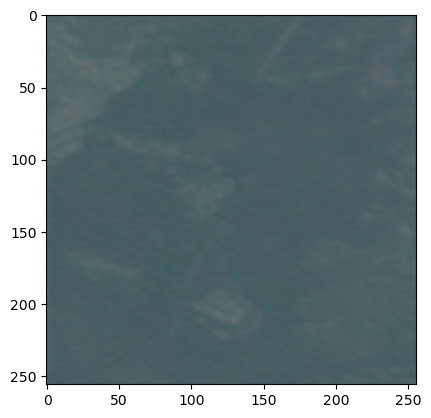

In [112]:
plt.imshow(test_prediction[0, :3].moveaxis(0, -1).detach().cpu())
plt.show()

In [116]:
metrics = pd.DataFrame(
    0.0,
    index=dataset.data.index,
    columns=["SSIM11", "SSIM51", "PSNR", "SSIM11_10K", "SSIM51_10K", "PSNR_10K"]
)
metrics

SSIM11  SSIM51  PSNR  SSIM11_10K  SSIM51_10K  \
ROI      tile patch timestep                                                 
ROIs1868 17   0     4            0.0     0.0   0.0         0.0         0.0   
                    10           0.0     0.0   0.0         0.0         0.0   
                    23           0.0     0.0   0.0         0.0         0.0   
                    26           0.0     0.0   0.0         0.0         0.0   
              1     4            0.0     0.0   0.0         0.0         0.0   
...                              ...     ...   ...         ...         ...   
ROIs2017 140  269   21           0.0     0.0   0.0         0.0         0.0   
                    22           0.0     0.0   0.0         0.0         0.0   
                    24           0.0     0.0   0.0         0.0         0.0   
                    26           0.0     0.0   0.0         0.0         0.0   
                    28           0.0     0.0   0.0         0.0         0.0   

                              PSNR_10K  
ROI      tile patch timestep            
ROIs1868 17   0     4              0.0  
                    10             0.0  
                    23             0.0  
                    26             0.0  
              1     4              0.0  
...                                ...  
ROIs2017 140  269   21             0.0  
                    22             0.0  
                    24             0.0  
                    26             0.0  
                    28             0.0  

[36293 rows x 6 columns]

In [120]:
val_loader = DataLoader(
    dataset,
    batch_size=32,
    num_workers=16,
    pin_memory=True,
    drop_last=False,
    shuffle=False
)

In [121]:
from spatiotemporal.imagefile import ImageFile
from os import makedirs
from osgeo import gdal

save_tif = dataset_manager.utils.save_tif_fast
path_to_predictions = join("/LOCAL2/shvl/predictions/CTGAN/SEN12MS-CR-TS/RUN_010", best_checkpoint[:-4])
BANDS = [3, 2, 1, 7]

In [122]:
generator = model

for step, batch in enumerate(tqdm(val_loader)):
    
    batch = {
        name: tensor.to(device=device, dtype=torch.float32, non_blocking=True)
        if not name == "index" else tensor
        for name, tensor in batch.items()
    }
    
    s2_filepaths = dataset.data.iloc[batch["index"].numpy()][(0, "S2")]

    inputs = [batch["S2_t-1"], batch["S2_t-2"], batch["S2_t-3"]]
    inputs = [rescale_s2(image) for image in inputs]
    target = batch["S2_t0"]
    rescaled_target = legacy_rescale_s2(target, old_version=False)  # Both target and output are in range [0..1]

    with torch.no_grad():
        prediction, [att0, att1, att2], [pred_0, pred_1, pred_2] = generator(inputs)
    
    for index, prediction_image, rescaled_target_image, target_image in zip(batch["index"], prediction, rescaled_target, target):

        # save rescaled metrics in [0..1] value range

        metrics.loc[metrics.index[index], "SSIM11"] = ssim(
            prediction_image.cpu().numpy(),
            rescaled_target_image.cpu().numpy(),
            win_size=11,
            data_range=1.0,
            channel_axis=0
        )
        metrics.loc[metrics.index[index], "SSIM51"] = ssim(
            prediction_image.cpu().numpy(),
            rescaled_target_image.cpu().numpy(),
            win_size=51,
            data_range=1.0,
            channel_axis=0
        )
        metrics.loc[metrics.index[index], "PSNR"] = psnr(
            prediction_image.cpu().numpy(),
            rescaled_target_image.cpu().numpy(),
            data_range=1.0,
        )

        s2_filepath = dataset.data.iloc[index.item()][(0, "S2")]

        unrescaled_prediction_image = rescale_s2_back(prediction_image)
        outfile = ImageFile(s2_filepath)
        outfile = outfile.set(root_dir=path_to_predictions)
        makedirs(outfile.directory, exist_ok=True)

        # Un-rescaled back to [0..10000]
        save_tif(
            target_path=outfile.filepath,
            output_image=unrescaled_prediction_image,
            path_to_donor_image=s2_filepath,
            gdal_dtype=gdal.GDT_UInt16
        )

        metrics.loc[metrics.index[index], "SSIM11_10K"] = ssim(
            unrescaled_prediction_image,
            target_image[BANDS].cpu().numpy(),
            win_size=11,
            data_range=10000,
            channel_axis=0
        )
        metrics.loc[metrics.index[index], "SSIM51_10K"] = ssim(
            unrescaled_prediction_image,
            target_image[BANDS].cpu().numpy(),
            win_size=51,
            data_range=10000,
            channel_axis=0
        )
        metrics.loc[metrics.index[index], "PSNR_10K"] = psnr(
            unrescaled_prediction_image,
            target_image[BANDS].cpu().numpy(),
            data_range=10000,
        )

    if step % 100:
        metrics.to_csv("CTGAN_metrics_per_image.csv")


    

100%|█████████████████████████████████████| 1135/1135 [1:33:15<00:00,  4.93s/it]


In [124]:
metrics.to_csv("CTGAN_metrics_per_image.csv")

# Run feature extractor

In [65]:
from CTGAN.datasets.s2_dataset import CTGAN_S2_Dataset
from torch.utils.data import DataLoader
from CTGAN.model.CTGAN import CTGAN_Generator
from tqdm import tqdm

In [7]:
dataset = CTGAN_S2_Dataset(
    dataset_manager, 
    min_target_area=0.95, 
    min_inputs_area=0.5,
    rescale=False,
    filter_bands=False,
    include_index=True,
    include_cloudmaps=False,
    include_cloud_cover=True
)
len(dataset)

156684

In [8]:
dataset_val = dataset.subset(s1_resampled=True, split="val", inplace=False)
dataset_test = dataset.subset(s1_resampled=True, split="test", inplace=False)
dataset.data = pd.concat([dataset_val.data, dataset_test.data], join="outer", axis=0)
del dataset_val
del dataset_test

len(dataset)

36293

In [64]:
val_loader = DataLoader(
    dataset,
    batch_size=1,
    num_workers=16,
    pin_memory=True,
    drop_last=False,
    shuffle=False
)

In [71]:
fe_metrics = pd.DataFrame(
    0.0,
    index=dataset.data.index,
    columns=["SSIM11", "SSIM51", "PSNR", "SSIM11_10K", "SSIM51_10K", "PSNR_10K"]
)
fe_metrics

SSIM11  SSIM51  PSNR  SSIM11_10K  SSIM51_10K  \
ROI      tile patch timestep                                                 
ROIs1868 17   0     4            0.0     0.0   0.0         0.0         0.0   
                    10           0.0     0.0   0.0         0.0         0.0   
                    23           0.0     0.0   0.0         0.0         0.0   
                    26           0.0     0.0   0.0         0.0         0.0   
              1     4            0.0     0.0   0.0         0.0         0.0   
...                              ...     ...   ...         ...         ...   
ROIs2017 140  269   21           0.0     0.0   0.0         0.0         0.0   
                    22           0.0     0.0   0.0         0.0         0.0   
                    24           0.0     0.0   0.0         0.0         0.0   
                    26           0.0     0.0   0.0         0.0         0.0   
                    28           0.0     0.0   0.0         0.0         0.0   

                              PSNR_10K  
ROI      tile patch timestep            
ROIs1868 17   0     4              0.0  
                    10             0.0  
                    23             0.0  
                    26             0.0  
              1     4              0.0  
...                                ...  
ROIs2017 140  269   21             0.0  
                    22             0.0  
                    24             0.0  
                    26             0.0  
                    28             0.0  

[36293 rows x 6 columns]

In [72]:
from spatiotemporal.imagefile import ImageFile
from os import makedirs
from osgeo import gdal

save_tif = dataset_manager.utils.save_tif_fast
path_to_predictions = join("/LOCAL2/shvl/predictions/CTGAN_FEATURE_EXTRACTOR/RUN_010", best_checkpoint[:-4])
BANDS = [3, 2, 1, 7]

In [79]:
for batch in tqdm(val_loader):

    with torch.no_grad():
    
        index = batch["index"].item()
    
        target_image = batch["S2_t0"][0]
        rescaled_target_image = legacy_rescale_s2(target_image, old_version=False).detach().cpu().numpy()
        target_image = target_image[BANDS].detach().cpu().numpy()
    
        best_t = None
        best_cloudfree_area = 0.0
        for t in [-1, -2, -3]:
            if batch[f"CLOUDFREEAREA_t{t}"].item() > best_cloudfree_area + 0.01:
                best_cloudfree_area = batch[f"CLOUDFREEAREA_t{t}"].item()
                best_t = t
        
        input_image = rescale_s2(batch[f"S2_t{best_t}"])
    
        
        _, _, prediction = feature_extractor(input_image.to(device))
        
    
        prediction = prediction.detach().cpu().numpy()[0]
        unrescaled_prediction = rescale_s2_back(prediction)
    
        s2_filepath = dataset.data.iloc[batch["index"].item()][(0, "S2")]
    
        outfile = ImageFile(s2_filepath)
        outfile = outfile.set(root_dir=path_to_predictions)
        makedirs(outfile.directory, exist_ok=True)
    
        fe_metrics.loc[fe_metrics.index[index], "SSIM11"] = ssim(
            prediction,
            rescaled_target_image,
            win_size=11,
            data_range=1.0,
            channel_axis=0
        )
        fe_metrics.loc[fe_metrics.index[index], "SSIM51"] = ssim(
            prediction,
            rescaled_target_image,
            win_size=51,
            data_range=1.0,
            channel_axis=0
        )
        fe_metrics.loc[fe_metrics.index[index], "PSNR"] = psnr(
            prediction,
            rescaled_target_image,
            data_range=1.0,
        )
    
        # Un-rescaled back to [0..10000]
        save_tif(
            target_path=outfile.filepath,
            output_image=unrescaled_prediction,
            path_to_donor_image=s2_filepath,
            gdal_dtype=gdal.GDT_UInt16
        )
    
        fe_metrics.loc[fe_metrics.index[index], "SSIM11_10K"] = ssim(
            unrescaled_prediction,
            target_image,
            win_size=11,
            data_range=10000,
            channel_axis=0
        )
        fe_metrics.loc[fe_metrics.index[index], "SSIM51_10K"] = ssim(
            unrescaled_prediction,
            target_image,
            win_size=51,
            data_range=10000,
            channel_axis=0
        )
        fe_metrics.loc[fe_metrics.index[index], "PSNR_10K"] = psnr(
            unrescaled_prediction,
            target_image,
            data_range=10000,
        )

100%|█████████████████████████████████████| 36293/36293 [45:03<00:00, 13.42it/s]


In [80]:
fe_metrics.to_csv("CTGAN_Feature_Extractor_metrics_per_image.csv")